<a href="https://colab.research.google.com/github/Ekliipce/Machine-Learning-for-Biomedical/blob/main/molecules/Generating_molecules_for_drug_discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import confusion_matrix
from keras.layers import LSTM, Dropout, Dense, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from keras.preprocessing.text import Tokenizer
from keras import Sequential
from tqdm import tqdm

# RNN Based molucule generation

Laurent Cetinsoy

In this hands-on we want to generate molecule formulas for denovo-drug discovery.

For that we need to use Generative models. Generative models are models which goes beyond classification or simple regression : they are able to generate data that look like previously seens dataset.

There exists a lot of models :

- Bayesian models like graphical models
- Recurrent models (for sequence generation like texte)
- Variational auto encoders
- Generative adversarial models
- Flow and diffusion models


In the hands-on we will start by  trainning a character based RNN to generate smile molecules


We want to feed smile representations of molecules to an RNN.
The basic idea is we will train it to predict the next smile token of a molecule given the previous one.

For instance for the following molecule "CC(=O)NC1=CC=C(O)C=C1" will may give to the model

X = "CC(=O)N"
y = C

and ask the RNN to learn to predict y given X

Like a standard language model !


## RNN Language model


A language model is a model which predict the next token of a sequence given the previous ones :

$ P(X_t | X_{t-1}, X_{t-2}, ..., X_{t-p})  $


This model can be learned with a Recurrent neural network

$ y = P(X_t | X_{t-1}, X_{t-2}, ..., X_{t-p}) = RNN_{\theta} (X_{t-1}, X_{t-2}, ..., X_{t-p})  $


In order to train such model you need a corpus of data.



There are two main ways to do that : Word level model or character level model

For character level models, an interesting resource is : http://karpathy.github.io/2015/05/21/rnn-effectiveness/



Explain briefly what is the difference between word based language model and character based language model ?

A word-based RNN can generate text using words from the training corpus but never new words. In contrast, a character-based RNN can produce new words. This property is interesting because we aim to create new molecules, which can be represented as words.

## Loading the data

Dowload the following dataset : https://github.com/joeymach/Leveraging-VAE-to-generate-molecules

Import pandas and load the first 1000 lines

In [2]:
!wget  'https://raw.githubusercontent.com/joeymach/Leveraging-VAE-to-generate-molecules/master/250k_smiles.csv'

--2023-09-26 09:03:57--  https://raw.githubusercontent.com/joeymach/Leveraging-VAE-to-generate-molecules/master/250k_smiles.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22606589 (22M) [text/plain]
Saving to: ‘250k_smiles.csv’

250k_smiles.csv     100%[===================>]  21.56M  --.-KB/s    in 0.06s   

2023-09-26 09:03:59 (369 MB/s) - ‘250k_smiles.csv’ saved [22606589/22606589]



Display the first rows of the dataframe

In [3]:
path_dataframe = "250k_smiles.csv"
df = pd.read_csv(path_dataframe)
df.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [4]:
df.shape

(249455, 4)

In [5]:
df.loc[1000, 'smiles']

'[NH3+][C@@H](CSCc1nccs1)C(=O)[O-]\n'

## Processing the data

We need to do the following things :

- convert smile tokens to numbers
- build  smile token sequences and corresponding labels pairs

Compute the biggest smile molecule size

In [6]:
biggest_smile_index = df['smiles'].apply(len).argmax()
biggest_smile = df['smiles'][biggest_smile_index]
biggest_smile

'C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2CC[C@@]2(C)[C@H]1CC[C@H]2O[C@@H]1O[C@H](C(=O)[O-])[C@@H](O)[C@H](O)[C@H]1O\n'


Code a function **unic_characters(string)** which return the unic characters in a string


In [7]:
def unic_characters(str_):
  res = ""
  for s in set(str_):
    res += s
  return res

unic_characters(biggest_smile)

'=OH1\nC2)(@]-['

Concatenate all smile string of the pandas dataframe and use **unic_characters** to get the unic_characters

In [8]:
all = ""
for str_ in df['smiles']:
  all += str_

unic_c = unic_characters(all)
unic_c

'/S7[HcPC)r@N4Bo86Is\n2F(+ln5]#=\\13O-'

In [9]:
list_unic = np.sort(list(unic_c))
list_unic

array(['\n', '#', '(', ')', '+', '-', '/', '1', '2', '3', '4', '5', '6',
       '7', '8', '=', '@', 'B', 'C', 'F', 'H', 'I', 'N', 'O', 'P', 'S',
       '[', '\\', ']', 'c', 'l', 'n', 'o', 'r', 's'], dtype='<U1')

Code a function **map_char_to_int(unic_chars)** which returns a dictionnary where each char is assigned an int value.
Add a character to specify the end of the molecule (like "\n")


In [10]:
def map_char_to_int(unic_chars):
  range_ = np.arange(unic_chars.shape[0])
  pair = zip(unic_chars, range_)
  return dict(pair)

char_to_int = map_char_to_int(list_unic)
char_to_int

{'\n': 0,
 '#': 1,
 '(': 2,
 ')': 3,
 '+': 4,
 '-': 5,
 '/': 6,
 '1': 7,
 '2': 8,
 '3': 9,
 '4': 10,
 '5': 11,
 '6': 12,
 '7': 13,
 '8': 14,
 '=': 15,
 '@': 16,
 'B': 17,
 'C': 18,
 'F': 19,
 'H': 20,
 'I': 21,
 'N': 22,
 'O': 23,
 'P': 24,
 'S': 25,
 '[': 26,
 '\\': 27,
 ']': 28,
 'c': 29,
 'l': 30,
 'n': 31,
 'o': 32,
 'r': 33,
 's': 34}

In [11]:
def transform_char(string):
  return [char_to_int[s] for s in string]

sample_1 = "CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n"
ex_1 = transform_char(sample_1)

Code a function map_int_to_char(unic_chars) which returns the reverse mapping.

In [12]:
def map_int_to_char(unic_chars):
  range_ = np.arange(unic_chars.shape[0])
  pairs = zip(range_, unic_chars)
  return dict(pairs)

int_to_char = map_int_to_char(list_unic)
int_to_char

{0: '\n',
 1: '#',
 2: '(',
 3: ')',
 4: '+',
 5: '-',
 6: '/',
 7: '1',
 8: '2',
 9: '3',
 10: '4',
 11: '5',
 12: '6',
 13: '7',
 14: '8',
 15: '=',
 16: '@',
 17: 'B',
 18: 'C',
 19: 'F',
 20: 'H',
 21: 'I',
 22: 'N',
 23: 'O',
 24: 'P',
 25: 'S',
 26: '[',
 27: '\\',
 28: ']',
 29: 'c',
 30: 'l',
 31: 'n',
 32: 'o',
 33: 'r',
 34: 's'}

In [13]:
def transform_int(arr):
  return [int_to_char[i] for i in arr]

print(sample_1)
transform_int(ex_1)

CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1



['C',
 'C',
 '(',
 'C',
 ')',
 '(',
 'C',
 ')',
 'c',
 '1',
 'c',
 'c',
 'c',
 '2',
 'o',
 'c',
 'c',
 '(',
 'C',
 'C',
 '(',
 '=',
 'O',
 ')',
 'N',
 'c',
 '3',
 'c',
 'c',
 'c',
 'c',
 'c',
 '3',
 'F',
 ')',
 'c',
 '2',
 'c',
 '1',
 '\n']

For each smile molecule add the ending token to it)

In [14]:
df[~df['smiles'].str.endswith('\n')]

,smiles,logP,qed,SAS


In [15]:
assert df['smiles'].str.endswith('\n').shape[0] == df.shape[0]

None smile doesn't end with '\n'


## Building the dataset

Now we will create the dataset so that it has the good share for our Keras LSTM model

Remember Keras recurrent models expect a 3D array with shapes (n_examples, seq_len, n_features)



What will be n_features in our case ?<br>
n_features will be the number of unique characters that appear in the dataset

Code a function **build_X_and_y(string, i_char, seq_lenght)** which takes a string, a **seq_length** number and a position.


It should create X by by getting all character between i and i + seq_length
and create y by getting the character following the X sequence
it returns X and y

Test your function on the following string "" with seq_length = 4 and i = [1, 2, 3]

In [16]:
def build_X_and_y(string, i_char, seq_length):
  if (i_char + seq_length > len(string)):
    return "", ""
  X = string[i_char:i_char + seq_length]

  if (i_char + seq_length + 1 > len(string)):
    return X, ""

  y = string[i_char + seq_length]
  return X, y


string = "jambondenoel"
seq_length = 9
i_char = 2
build_X_and_y(string, i_char, seq_length)


('mbondenoe', 'l')

By using build_X_and_y and map_char_to_int build a list nameed X_train and a list named y_train

In [17]:
samples = df["smiles"]
x_train = []
y_train = []

seq_length = 20
for smile in tqdm(samples):
  for pos in range(0, len(smile) - seq_length):
    x, y = build_X_and_y(smile, pos, seq_length)
    x_train.append(transform_char(x))
    y_train.append(transform_char(y))

x_train[0], y_train[0]

100%|██████████| 249455/249455 [00:32<00:00, 7614.85it/s]


([18, 18, 2, 18, 3, 2, 18, 3, 29, 7, 29, 29, 29, 8, 32, 29, 29, 2, 18, 18],
 [2])

Create numpy arrays from the lists

In [18]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train.shape, y_train.shape

((6314835, 20), (6314835, 1))

Reshape the X numpy array (n_examples, seq_lenght, 1)

In [19]:
n_examples = x_train.shape[0]
x_train = x_train.reshape(n_examples, seq_length, 1)
x_train.shape

(6314835, 20, 1)

Normalize X by dividing each values by the total number of unic characters

In [20]:
nb_unic = len(char_to_int)
x_train = x_train / nb_unic
x_train[0]

array([[0.51428571],
       [0.51428571],
       [0.05714286],
       [0.51428571],
       [0.08571429],
       [0.05714286],
       [0.51428571],
       [0.08571429],
       [0.82857143],
       [0.2       ],
       [0.82857143],
       [0.82857143],
       [0.82857143],
       [0.22857143],
       [0.91428571],
       [0.82857143],
       [0.82857143],
       [0.05714286],
       [0.51428571],
       [0.51428571]])

Import Keras and build (at least) a two layered LSTM network with 128 neurone in each.

You can also add Dropoutlayers

Do you think you should use the return_sequences = True ? If yes, when ?
As the LSTM layer will return the full sequence to the next layer instead of just the final output, we should set return_sequences=True for all LSTM layers except the last one to predict several atoms

Add a Dense layer on top with with the appropriate activation function and number of neurones


In [21]:
model = Sequential([
    LSTM(128, input_shape=(seq_length, 1), return_sequences=True, dropout=0,
         activation="tanh", recurrent_activation="sigmoid"),
    #LSTM(128, return_sequences=True, dropout=0,
    #     activation="tanh", recurrent_activation="sigmoid"),
    LSTM(128,
         activation="tanh", recurrent_activation="sigmoid"),
    Dense(nb_unic, activation="softmax")
])

Compile the model with the appropriate loss function and the adam optimizer

In [22]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics="accuracy")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 35)                4515      
                                                                 
Total params: 202659 (791.64 KB)
Trainable params: 202659 (791.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Train the model on 20 epochs and 10 examples (yeah you read correctly) and check that the model overfits !

In [23]:
y_train_one_hot = tf.keras.utils.to_categorical(y_train)
history = model.fit(x=x_train[:10],
                    y=y_train[:10],
                    epochs=20,
                    validation_split=0.2)

Epoch 1/20
1/1 [==============================] - 9s 9s/step - loss: 3.5536 - accuracy: 0.1250 - val_loss: 3.4318 - val_accuracy: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 54ms/step - loss: 3.5030 - accuracy: 0.2500 - val_loss: 3.3296 - val_accuracy: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 37ms/step - loss: 3.4442 - accuracy: 0.2500 - val_loss: 3.1899 - val_accuracy: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 37ms/step - loss: 3.3668 - accuracy: 0.2500 - val_loss: 2.9837 - val_accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 38ms/step - loss: 3.2570 - accuracy: 0.2500 - val_loss: 2.6680 - val_accuracy: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 38ms/step - loss: 3.0959 - accuracy: 0.2500 - val_loss: 2.1904 - val_accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 38ms/step - loss: 2.8664 - accuracy: 0.2500 - val_loss: 1.5590 - val_accuracy: 1.0000
Epoch 8/20
1/1 [=============

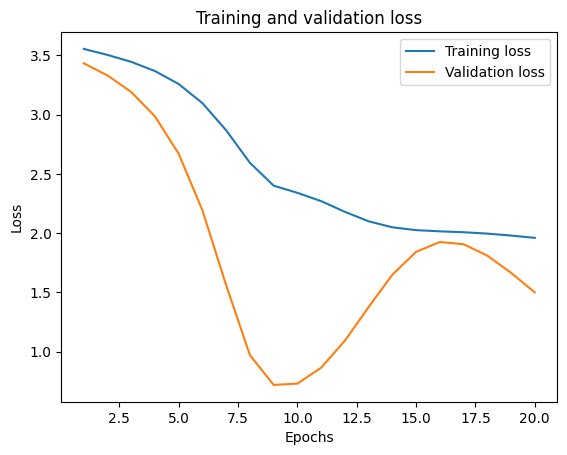

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


In [25]:
test_loss, test_accuracy = model.evaluate(x_train[20:2000], y_train[20:2000])

print(f"Accuracy on train : {history.history['accuracy'][-1]}")
print(f"Accuracy on test (other train data) : {test_accuracy}")

62/62 [==============================] - 0s 4ms/step - loss: 4.4554 - accuracy: 0.2061
Accuracy on train : 0.25
Accuracy on test (other train data) : 0.20606060326099396


If it does not overfit try to fix data prep and model architecture so it does

Create a function **make_prediction(seed_start)** which takes a starting string sequence and uses it to generate a molecule


In [26]:
def make_inputs(string):
  len_ = len(string)
  inputs = np.array(transform_char(string), dtype="float").reshape(1, len_, 1)
  inputs /=  model.output_shape[1]
  return inputs

make_inputs(df['smiles'][1][:3])

array([[[0.51428571],
        [0.74285714],
        [0.51428571]]])

In [27]:
def make_prediction(seed_start, model, max_len=20):
    mol = seed_start

    i = 0
    while(True):
        token_int = [np.argmax(model.predict(make_inputs(mol), verbose=0))]
        token = transform_int(token_int)[0]
        mol += token

        if (token == '\n' or i > max_len):
            break
        i += 1

    return mol

generate a molecule of your overfitted model

In [28]:
make_prediction(df['smiles'][1][:seq_length], model)

'C[C@@H]1CC(Nc2cncc(-cccccccccccccccccccccc'

Make a model checkpoint so that the model is saved after each epoch
if you train on a plateform and it stops you do not lose your training

In [29]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='.',
    monitor='val_accuracy',
    save_best_only=False)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.05,
                              patience=2,
                              verbose=1,
                              min_delta=0.0001)
early_stop = EarlyStopping(monitor='val_loss',
                           patience=3,
                           verbose=1,
                           restore_best_weights=True)

Now go to your favorite plateform (colab or something else) and train the dataset on the whole data for 10 epochs and batch size 256

it should take a long time so either follow the class or go take a nap

In [30]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
  model2 = Sequential([
      LSTM(128, input_shape=(seq_length, 1), return_sequences=True,
            recurrent_dropout=0.1, activation="tanh", recurrent_activation="sigmoid"),
      Dropout(0.1),
      BatchNormalization(),
      LSTM(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1,
          activation="tanh", recurrent_activation="sigmoid"),
      BatchNormalization(),
      LSTM(128, recurrent_dropout=0.1,
            activation="tanh", recurrent_activation="sigmoid"),
      Dropout(0.1),
      BatchNormalization(),
      Dense(nb_unic, activation="softmax")
  ])

  model2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics="accuracy")
  history = model2.fit(x=x_train[:100000],
                      y=y_train_one_hot[:100000],
                      epochs=10,
                      validation_split=0.1,
                      batch_size=256,
                      callbacks=[model_checkpoint_callback,
                                reduce_lr])

Epoch 1/10
352/352 [==============================] - 63s 163ms/step - loss: 2.3941 - accuracy: 0.3219 - val_loss: 3.3194 - val_accuracy: 0.1316 - lr: 0.0010
Epoch 2/10
352/352 [==============================] - 58s 164ms/step - loss: 1.6275 - accuracy: 0.4897 - val_loss: 1.9640 - val_accuracy: 0.3896 - lr: 0.0010
Epoch 3/10
352/352 [==============================] - 57s 161ms/step - loss: 1.4315 - accuracy: 0.5413 - val_loss: 1.3062 - val_accuracy: 0.5812 - lr: 0.0010
Epoch 4/10
352/352 [==============================] - 57s 161ms/step - loss: 1.3306 - accuracy: 0.5696 - val_loss: 1.2588 - val_accuracy: 0.5934 - lr: 0.0010
Epoch 5/10
352/352 [==============================] - 56s 159ms/step - loss: 1.2628 - accuracy: 0.5867 - val_loss: 1.1802 - val_accuracy: 0.6157 - lr: 0.0010
Epoch 6/10
352/352 [==============================] - 56s 160ms/step - loss: 1.2137 - accuracy: 0.6006 - val_loss: 1.1214 - val_accuracy: 0.6361 - lr: 0.0010
Epoch 7/10
352/352 [==============================] 

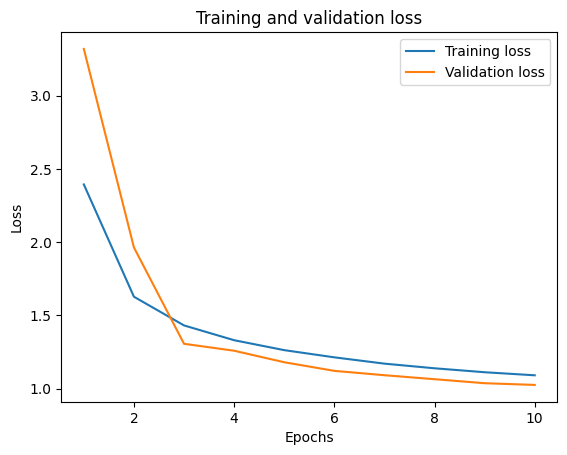

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


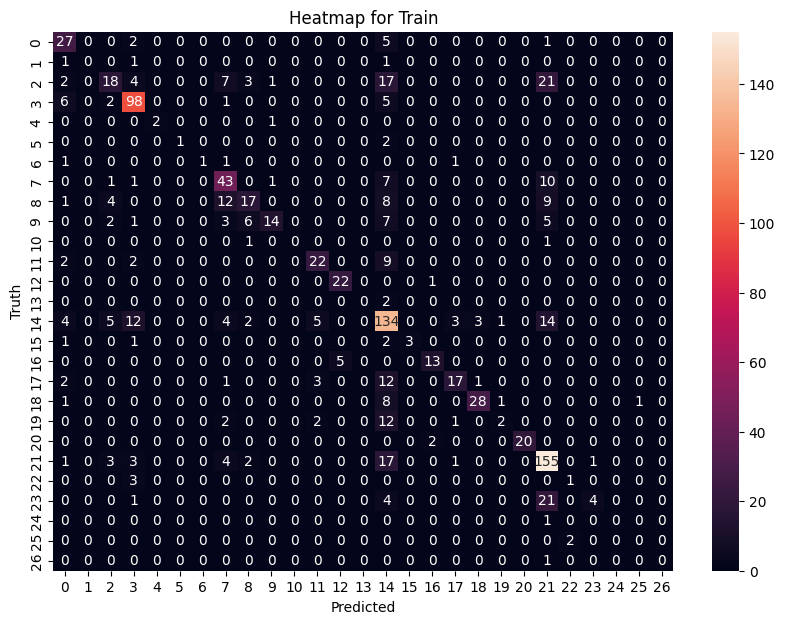

In [32]:
y_pred = np.argmax(model2.predict(x_train[:1000], verbose=0), axis=1)
y_true = y_train[:1000]

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title("Heatmap for Train")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()



In [33]:
model2.save('/kaggle/working/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Generate between 100 and 1000 molecules.

create a list where molecules have between 10 and 50 atoms

In [34]:
%%time
base_molecules = [item[:20] for item in df['smiles'][:50]]
predictions = [make_prediction(base_molecules[i], model2, 50) for i in tqdm(range(50))]

100%|██████████| 50/50 [01:21<00:00,  1.63s/it]

CPU times: user 1min 19s, sys: 2.86 s, total: 1min 22s
Wall time: 1min 21s


In [37]:
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import QED


real_mol = [Chem.MolFromSmiles(mol) for mol in predictions if mol is not None]
real_mol = [mol for mol in real_mol if mol is not None]
real_mol

[09:21:53] SMILES Parse Error: unclosed ring for input: 'CC(C)(C)c1ccc2occ(CC(=O)Nc2ccc(C)cc2)CC1
'
[09:21:53] SMILES Parse Error: extra open parentheses for input: 'C[C@@H]1CC(Nc2cncc(-c2ccccc2)CC1
'
[09:21:53] SMILES Parse Error: extra open parentheses for input: 'N#Cc1ccc(-c2ccc(O[C@@H]3CCCC[C@H]3C2)cc1
'
[09:21:53] SMILES Parse Error: extra open parentheses for input: 'CCOC(=O)[C@@H]1CCCN(C(=O)CC1
'
[09:21:53] SMILES Parse Error: extra close parentheses while parsing: CC[NH+](CC)[C@](C)(C)C)C1

[09:21:53] SMILES Parse Error: Failed parsing SMILES 'CC[NH+](CC)[C@](C)(C)C)C1
' for input: 'CC[NH+](CC)[C@](C)(C)C)C1
'
[09:21:53] SMILES Parse Error: extra open parentheses for input: 'CCOc1ccc(OCC)c([C@H]2CCC[C@@H]2C(=O)Nc1ccc(C)cc1
'
[09:21:53] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc2nc(S[C@H](C)C(=O)Nc3ccccc3)CC2)cc1

[09:21:53] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc2nc(S[C@H](C)C(=O)Nc3ccccc3)CC2)cc1
' for input: 'Cc1ccc2nc(S[C@H](C)C(=O)Nc3ccccc3)

With rdkit compute the Quantified Estimated Drug likelyness (QED) of each molecule in this subset

In [36]:
qed_values = [QED.qed(mol) for mol in real_mol if mol is not None]
qed_values

[0.9016280634364917,
 0.9036662356629043,
 0.739699211881737,
 0.6936363269741198,
 0.6626651434625582,
 0.6695330678830024,
 0.8631162579916883,
 0.8071321677652429,
 0.8230298633906286,
 0.8393809316039298,
 0.8208921608896567,
 0.8032238530926873,
 0.8227755154416257,
 0.5876697015220248,
 0.768690926756413,
 0.7528534472059415,
 0.9163013229848028,
 0.8374728849440837,
 0.8090451803378943]

In [40]:
new_mols = [mol for mol in real_mol if mol not in df['smiles']]
len(new_mols)

19

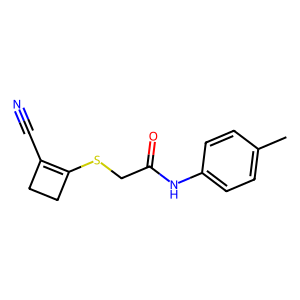

In [41]:
Chem.Draw.MolToImage(new_mols[0])

Bonus 1 : Using rdkit, compute the quantitative estimation of drug-likeness (QED) of your generated molecules.

Bonus 2 : try to adapt a transformer model training from hugging face to see if it is better